<a href="https://colab.research.google.com/github/harisA1/Hydrological-Model-Bias-Correction/blob/main/Bias_Correction_HEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hydrological Model Bias Correction: Predicting Systematic Errors due to Human Interventions



*   Hydrological models based on physical processes (like HEC-HMS) are essential tools for predicting river discharge and water resource management. However, human interventions such as irrigation significantly alter hydrological responses, creating systematic biases in model predictions.

*   In this case study, extensive agricultural activity—specifically farmers draining water for irrigation—causes the model to consistently overestimate river discharge especially during the summer months. This systematic error necessitates bias correction to improve predictive accuracy, supporting better water resource planning and management.







In [52]:
import pandas as pd
df=pd.read_csv('hec_out2.csv')
df=df.rename(columns={'Obs Flow (M3/S)':'observed','Outflow (M3/S)':'output'})
df.head(n=2)

,output,observed
0,0.0,0.6
1,0.0,0.6


To better understand the systematic error, we visualize the observed versus model-predicted river discharge. The following plot clearly illustrates the model's tendency to overestimate discharge, particularly noticeable during the summer irrigation months.


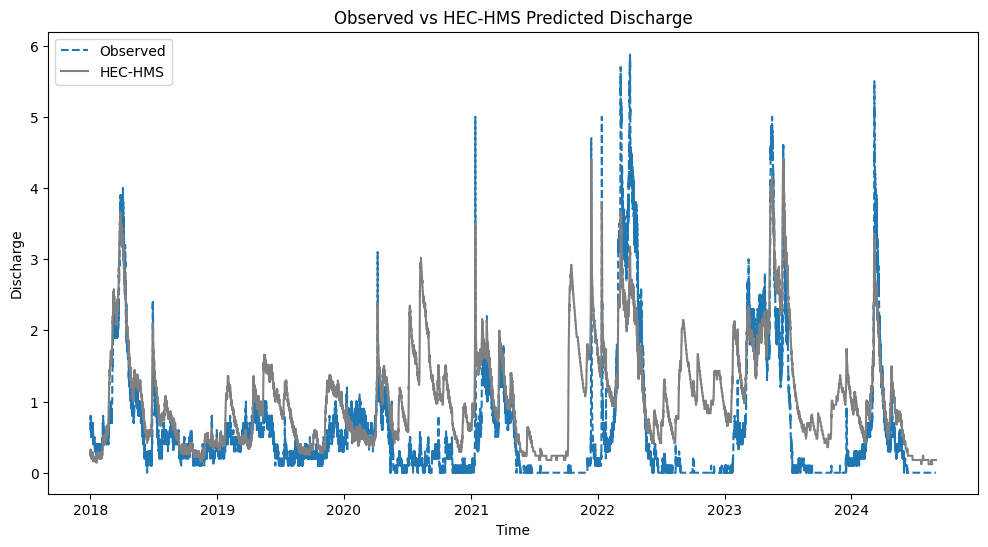

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df['observed'], label='Observed',linestyle='dashed')
plt.plot(df['output'], label='HEC-HMS',color='grey')
plt.xlabel('Time')
plt.ylabel('Discharge')
plt.title('Observed vs HEC-HMS Predicted Discharge')
plt.legend()
plt.show()

Next, we enrich our dataset by extracting time-based features such as season, hour, day, and month. These features will help our bias correction model capture temporal patterns associated with systematic errors in hydrological predictions.


In [55]:
# Parameters
start_date = '2018-01-01'  # specify your start date
num_periods = len(df)            # specify the number of dates to generate
frequency = 'h'            # frequency: 'D' for daily, 'H' for hourly, etc.

# Creating the datetime column
date_range = pd.date_range(start=start_date, periods=num_periods, freq=frequency)

# Creating a DataFrame and adding the datetime column
df['Datetime'] = date_range
df['Datetime']=pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
# Function to get season based on month
def get_season(month):
    if 3 <= month <= 5:
        return 'Spring'  # Spring
    elif 6 <= month <= 8:
        return 'Summer'  # Summer
    elif 9 <= month <= 11:
        return 'Autumn'  # Autumn
    else:
        return 'Winter'  # Winter
# Add a 'season' column to the DataFrame
df['Season'] = df.index.month.map(get_season)
# Assuming 'Season' is a categorical column in your DataFrame
df = pd.get_dummies(df, columns=['Season'])
df['Hour']= df.index.hour
df['Day'] = df.index.day
df['Month'] = df.index.month
df['er']= df['observed']-df['output']
df.head(n=2)

,output,observed,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Hour,Day,Month,er
Datetime,,,,,,,,,,
2018-01-01 00:00:00,0.0,0.6,False,False,False,True,0,1,1,0.6
2018-01-01 01:00:00,0.0,0.6,False,False,False,True,1,1,1,0.6


We filter the dataset to focus on July to December (when overestimation due to irrigation is prominent), and split it into training and test sets while preserving temporal order, aiming to predict the model's error (er).

In [30]:
from sklearn.model_selection import train_test_split

#  Specify the months  to keep
months_to_keep = [7,8,9,10,11,12]
# Filter the DataFrame to only include rows from the specified months
filtered_df = df[df.index.month.isin(months_to_keep)]
data = filtered_df.copy()

X = data.drop(columns=['er','observed'])  # Features (exclude 'er' and 'observed')
y = data['er']  # Target variable ('er')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) # shuffle=False to maintain time order
print(len(X_train))
print(len(X_test))

26535
6634


In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.cross_decomposition import PLSRegression

# Initialize the regression model
# model=RandomForestRegressor()
# model = xgb.XGBRegressor()
# model= LGBMRegressor()
# model=PLSRegression(n_components=1)
model=MLPRegressor(learning_rate='adaptive', max_iter=2000)

# Fit the model on the training data
model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = model.predict(X_test)
# Evaluate the model (example using R-squared)
r2 = r2_score(y_test, y_pred)
print(f"R2: {r2}")


R2: 0.8138074379697298


Generate predictions for both training and testing sets, merging them into a single DataFrame indexed by datetime to visualize the predicted errors in temporal order.

In [44]:
# Generate predictions on both sets
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
# Create DataFrames for predictions using the datetime index from X_train and X_test
df_train_preds = pd.DataFrame({'Prediction': train_preds}, index=X_train.index)
df_test_preds = pd.DataFrame({'Prediction': test_preds}, index=X_test.index)

# Merge the predictions into one DataFrame and sort by the datetime index to preserve the sequence
df_all_preds = pd.concat([df_train_preds, df_test_preds]).sort_index()

# Display the merged DataFrame
df_all_preds.head()

,Prediction
Datetime,
2018-01-01 00:00:00,0.590006
2018-01-01 01:00:00,0.567115
2018-01-01 02:00:00,0.552100
2018-01-01 03:00:00,0.557699
2018-01-01 04:00:00,0.574112


We use Modified Kling-Gupta efficiency to evaluate our models predictions [Kling et al 2012](https://doi.org/10.1016/j.jhydrol.2012.01.011)

In [62]:
import numpy as np
def mod_kge(y_true,y_pred):
  m1, m2 = np.mean(y_true, axis=0), np.mean(y_pred, axis=0)
  num_r = np.sum((y_true - m1) * (y_pred - m2), axis=0)
  den_r = np.sqrt(np.sum((y_true - m1) ** 2, axis=0)) * np.sqrt(np.sum((y_pred - m2) ** 2, axis=0))
  r = num_r / den_r
  beta = m2 / m1
  gamma = (np.std(y_pred, axis=0) / m2) / (np.std(y_true, axis=0) / m1)
  result = 1 - np.sqrt((r - 1) ** 2 + (beta - 1) ** 2 + (gamma - 1) ** 2)
  return result

In [63]:
# Merge the predictions into the original DataFrame based on the datetime index.
# Using a left join ensures that the final DataFrame retains all rows from df_original.
df_merged = df.join(df_all_preds, how='left')
# Replace NaNs in the 'Prediction' column with 0.
# This ensures that for rows without a prediction, the addition results in the original 'output' value.
df_merged['Prediction'] = df_merged['Prediction'].fillna(0)
df_merged['Prediction'] = df_merged['output'] + df_merged['Prediction']
df_merged['Prediction'] = df_merged['Prediction'].clip(lower=0)

In [64]:
# calculate r2 metric between prediction and obs
r2 = r2_score(df_merged['observed'], df_merged['Prediction'])
print(f"NSE: {r2}")
kge = mod_kge(df_merged['observed'],df_merged['Prediction'])
print(f"MKGE: {kge}")


NSE: 0.7973452404992318
MKGE: 0.8685092647610123


The plot demonstrates that the original HEC-HMS model (gray) consistently overestimates discharge, especially during summer months when irrigation practices influence the water flow. After applying the bias correction (orange), predictions align significantly better with observed data (blue), highlighting the effectiveness of modeling errors caused by human activities to enhance hydrological prediction accuracy.

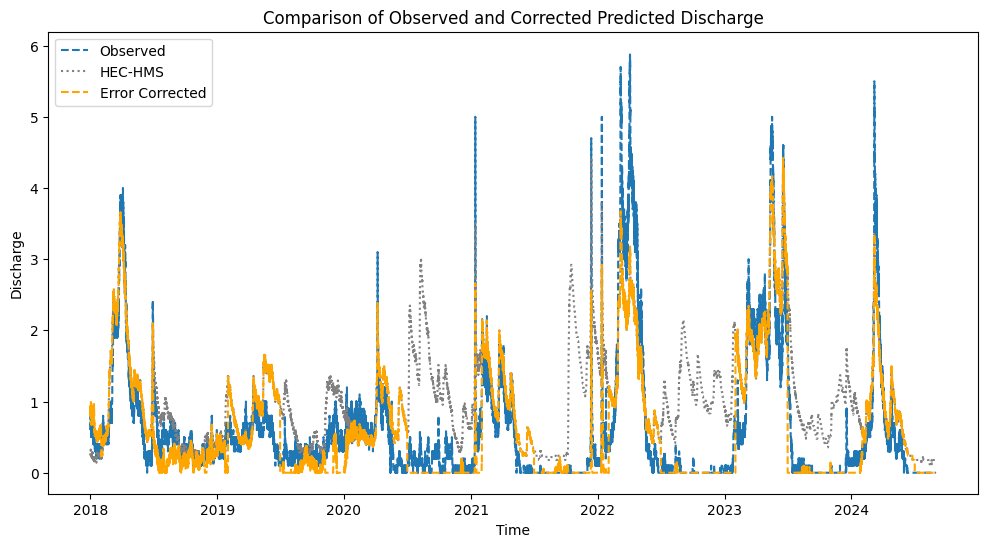

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df_merged['observed'], label='Observed',linestyle='dashed')
plt.plot(df_merged['output'], label='HEC-HMS',color='grey',linestyle='dotted')
plt.plot(df_merged['Prediction'], label='Error Corrected',linestyle='--',color='orange')
plt.xlabel('Time')
plt.ylabel('Discharge')
plt.title('Comparison of Observed and Corrected Predicted Discharge')
plt.legend()
plt.show()